# Import Required Libraries

In [1]:
import pyarrow.parquet as pq
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Data files

In [2]:
DATA_FILE_PATHS = '../data'
start_date = pd.to_datetime('2023-04-01 00:00:00')
end_date = pd.to_datetime('2023-05-01 00:00:00')

In [3]:
trips_pq = pq.read_table(DATA_FILE_PATHS)
trips_df = trips_pq.to_pandas()
trips_df.shape

(12672737, 19)

In [4]:
filtered_trips_df = trips_df[(trips_df['tpep_pickup_datetime'] >= start_date) & (
    trips_df['tpep_pickup_datetime'] < end_date)]

In [5]:
# Sort the DataFrame based on the 'tpep_pickup_datetime' column in ascending order
filtered_trips_df = filtered_trips_df.sort_values(by='tpep_pickup_datetime')

In [6]:
filtered_trips_df = filtered_trips_df.reset_index(drop=True)

In [7]:
filtered_trips_df['tpep_pickup_datetime'] = filtered_trips_df['tpep_pickup_datetime'].dt.date

In [8]:
filtered_trips_df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-04-01,2023-04-01 00:19:45,2.0,13.16,1.0,N,134,226,1,49.90,1.0,0.5,15.72,0.0,1.0,68.12,0.0,NaN
1,1,2023-04-01,2023-04-01 00:07:54,1.0,1.40,1.0,N,164,234,1,9.30,3.5,0.5,2.85,0.0,1.0,17.15,2.5,NaN
2,2,2023-04-01,2023-04-01 00:09:06,1.0,0.91,1.0,N,158,249,1,10.00,1.0,0.5,3.00,0.0,1.0,18.00,2.5,NaN
3,2,2023-04-01,2023-04-01 00:06:13,2.0,0.87,1.0,N,249,90,1,7.90,1.0,0.5,2.58,0.0,1.0,15.48,2.5,NaN
4,2,2023-04-01,2023-04-01 00:17:45,5.0,3.71,1.0,N,137,143,1,20.50,1.0,0.5,2.00,0.0,1.0,27.50,2.5,NaN
5,2,2023-04-01,2023-04-01 00:15:46,3.0,2.69,1.0,N,48,249,1,16.30,1.0,0.5,4.26,0.0,1.0,25.56,2.5,NaN
6,2,2023-04-01,2023-04-01 00:09:34,5.0,1.62,1.0,N,249,231,1,11.40,1.0,0.5,3.28,0.0,1.0,19.68,2.5,NaN
7,2,2023-04-01,2023-04-01 00:15:31,1.0,3.33,1.0,N,263,107,1,17.70,1.0,0.5,2.00,0.0,1.0,24.70,2.5,NaN
8,1,2023-04-01,2023-04-01 00:01:40,2.0,0.50,1.0,N,137,107,1,4.40,3.5,0.5,1.88,0.0,1.0,11.28,2.5,NaN
9,2,2023-04-01,2023-04-01 00:18:48,NaN,4.84,NaN,None,74,50,0,24.38,0.0,0.5,0.00,0.0,1.0,28.38,NaN,NaN


In [9]:
# 
grouped_df = filtered_trips_df.groupby(
    ['tpep_pickup_datetime', 'PULocationID']).size().reset_index(name='count')

In [10]:
grouped_df['tpep_pickup_datetime'] = pd.to_datetime(
    grouped_df['tpep_pickup_datetime'])

In [11]:
grouped_df['pred_count'] = grouped_df['count']

In [12]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tpep_pickup_datetime  6682 non-null   datetime64[ns]
 1   PULocationID          6682 non-null   int64         
 2   count                 6682 non-null   int64         
 3   pred_count            6682 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 208.9 KB


# Report by MAPE Metric

### Define MAPE Metric Function

In [13]:
# Define the MAPE calculation function
def calculate_mape(actual, predicted):
    return (abs((actual - predicted) / actual)).mean() * 100


# Calculate MAPE
mape = calculate_mape(grouped_df['count'], grouped_df['count'])
print("MAPE: {:.2f}%".format(mape))

MAPE: 0.00%


### Calculate MAPE per LocationID

In [14]:
def calculate_mape_locationID(df, PULocationID):
    selected_df = df[df['PULocationID'] == PULocationID]
    actual = selected_df['count']
    predicted = selected_df['pred_count']
    mape = calculate_mape(actual, predicted)
    return mape

In [15]:
locationID_mape = 263
calculate_mape_locationID(grouped_df, locationID_mape)
print("MAPE for LocationID {}: {:.2f}%".format(locationID_mape, mape))

MAPE for LocationID 263: 0.00%


### Calculate Average MAPE per all LocationIDs

In [16]:
PULocationIDs = grouped_df['PULocationID'].unique()
PULocationIDs.sort()
for locationID in PULocationIDs:
    mape_all = []
    mape_all.append(calculate_mape_locationID(grouped_df, locationID))
    AvgMAPE = sum(mape_all)/len(PULocationIDs)

print("Average MAPE per LocationIDs: {:.2f}%".format(mape))

Average MAPE per LocationIDs: 0.00%


## Visualization

Zones (Borough): **EWR, Queens, Bronx, Manhattan, Staten Island, Brooklyn**

Date Range: **2023-04-01_2023-04-30**

In [17]:
# This Function shows demand on map based on selected date on month
# Becuase of to many locationIDs, we limited our visualization to each zone(Borough)
def visualize_demand_zone_date(zone, date):
    shape = gpd.read_file('../map_data/taxi_zones/taxi_zones.shp')
    counts_PU = grouped_df.rename(columns={'PULocationID': 'LocationID'})
    counts_PU = counts_PU[counts_PU['tpep_pickup_datetime'] == date]
    merged_gdf = shape.merge(counts_PU, on='LocationID', how='left')
    merged_gdf_selected = merged_gdf[merged_gdf['borough'] == zone]
    # Create a figure with two subplots (maps side by side)
    fig, axes = plt.subplots(1, 2, figsize=(10, 8))

    # Plot the first map with 'count' column on the left subplot
    merged_gdf_selected.plot(
        column='count', cmap='Oranges', legend=True, ax=axes[0])
    axes[0].set_title('Actual')
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    for idx, row in merged_gdf_selected.iterrows():
        location_id = row['LocationID']
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        axes[0].text(x, y, str(location_id), fontsize=8,
                     ha='center', va='center', color='black')

    # Plot the second map with 'pred' column on the right subplot
    merged_gdf_selected.plot(
        column='pred_count', cmap='Blues', legend=True, ax=axes[1])
    axes[1].set_title('Prediction')
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    for idx, row in merged_gdf_selected.iterrows():
        location_id = row['LocationID']
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        axes[1].text(x, y, str(location_id), fontsize=8,
                     ha='center', va='center', color='black')

    plt.show()

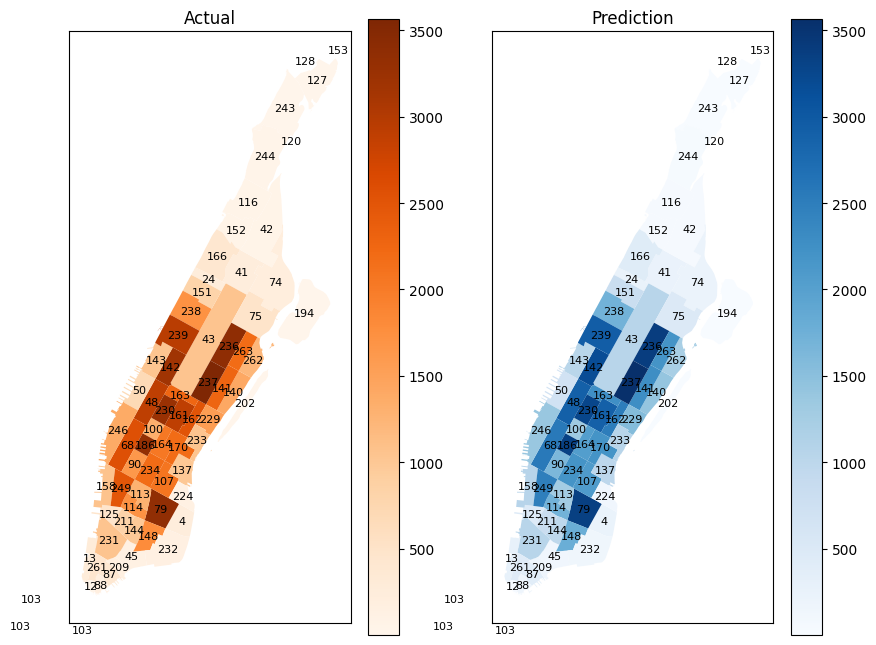

In [18]:
visualize_demand_zone_date('Manhattan', '2023-04-30')